In [1]:
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#smotk=SMOTETomek(random_state=139)
resample2=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_score, recall_score, f1_score, auc,roc_auc_score,cohen_kappa_score,matthews_corrcoef

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_frame = pd.read_csv('/content/drive/MyDrive/parkinsons.data')

In [4]:
num_0 = (data_frame["status"] == 0).sum()
num_1 = (data_frame["status"] == 1).sum()

print("number of rows with class0:",num_0)
print("number of rows with class1:",num_1)

number of rows with class0: 48
number of rows with class1: 147


# SMOTE+TOMEK+Augmentation

In [5]:
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
import numpy as np

# Assuming 'data_frame' is your DataFrame containing the data

# Step 1: Balancing using SMOTE+TOMEK
resample2 = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
x = data_frame.drop(["status", "name"], axis=1)
y = data_frame["status"]
x_res2, y_res2 = resample2.fit_resample(x, y)

# Step 2: Augmentation
data = np.column_stack((x_res2, y_res2))

x_balanced = data[:, :-1]
y_balanced = data[:, -1]

num_samples_to_add = 600

additional_samples_indices = np.concatenate([
    np.random.choice(np.where(y_balanced == 0)[0], num_samples_to_add // 2, replace=True),
    np.random.choice(np.where(y_balanced == 1)[0], num_samples_to_add // 2, replace=True)
])

x_augmented = np.vstack([x_balanced, x_balanced[additional_samples_indices]])
y_augmented = np.hstack([y_balanced, y_balanced[additional_samples_indices]])

print("Number of samples after augmentation:")
print("Class 0:", np.sum(y_augmented == 0))
print("Class 1:", np.sum(y_augmented == 1))

Number of samples after augmentation:
Class 0: 442
Class 1: 447


# Bagging Classifier

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Step 3: Feature Selection using LDA
lda = LinearDiscriminantAnalysis()
lda.fit(x_augmented, y_augmented)

# Set a threshold for feature selection
threshold = 1  # Adjust threshold as needed

# Get absolute coefficients and select features above threshold
selected_feature_indices = np.where(lda.coef_ > threshold)[1]

print(lda.coef_)

# Step 4: Select features with positive feature importance
selected_x = x_augmented[:, selected_feature_indices]

print(selected_x.shape)


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Step 5: Apply ensemble bagging with Decision Tree as base classifier
base_classifier = DecisionTreeClassifier()

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(selected_x, y_augmented, test_size=0.2, random_state=42)

# Initialize and fit the BaggingClassifier with Decision Tree as base classifier
bagging_classifier = BaggingClassifier(base_estimator=base_classifier, n_estimators=100, random_state=42)
bagging_classifier.fit(x_train, y_train)

# Predict on the test set
y_pred = bagging_classifier.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

[[-1.75537501e-02  4.95989290e-03 -5.82571736e-03 -2.55651998e+03
   3.78556568e+04  5.63037957e+04 -7.73874442e+02 -1.74049129e+04
   2.29952529e+02  1.08613930e+01  6.52184820e+04 -2.17272455e+02
   3.56385852e+01 -2.18182160e+04 -4.08697703e+01 -2.24133081e-02
  -6.88468692e+00 -2.23076782e-01  1.19622445e+00  1.53914287e+01
   1.50620068e+00  1.12924994e+01]]
(889, 10)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.9943820224719101


# Bagging

Accuracy: 0.9943820224719101
Precision: 0.9876543209876543
Recall: 1.0
F1-score: 0.9937888198757764
Confusion Matrix:
[[97  1]
 [ 0 80]]


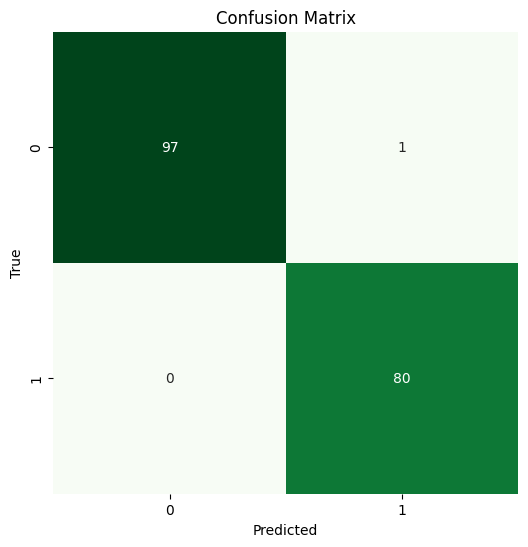

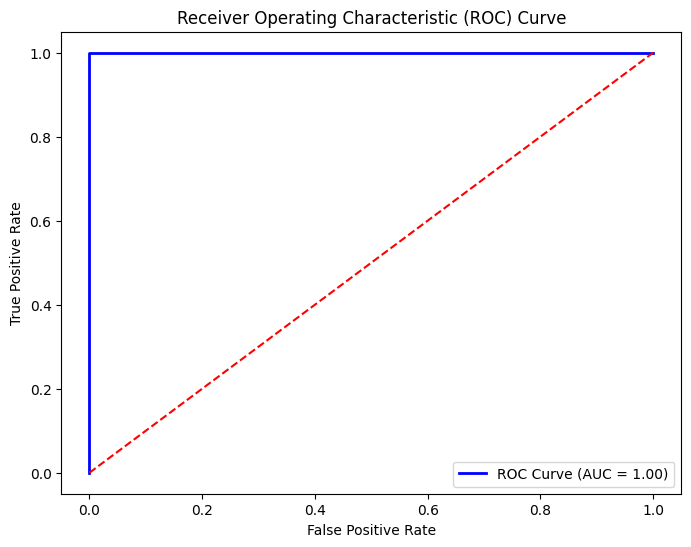

Accuracy: 0.9944 Precision: 0.9877 Recall: 1.0000 F1 Score: 0.9938 AUC Score: 0.9949 MCC: 0.9887 Kappa: 0.9887
Specificity: 0.9898


In [8]:
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_prob = bagging_classifier.predict_proba(x_test)[:, 1]

# Compute precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Plot ROC curve
y_pred_prob = bagging_classifier.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print('Accuracy: %.4f' % accuracy_score(y_test, y_pred), 'Precision: %.4f' % precision_score(y_test, y_pred), 'Recall: %.4f' % recall_score(y_test, y_pred),
      'F1 Score: %.4f' % f1_score(y_test, y_pred), 'AUC Score: %.4f' % roc_auc_score(y_test, y_pred),'MCC: %.4f' % matthews_corrcoef(y_test, y_pred), 'Kappa: %.4f' % cohen_kappa_score(y_test, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
print('Specificity: %.4f' % specificity)

# LDA + Boosting

Accuracy: 1.0
Confusion Matrix:
[[98  0]
 [ 0 80]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        98
         1.0       1.00      1.00      1.00        80

    accuracy                           1.00       178
   macro avg       1.00      1.00      1.00       178
weighted avg       1.00      1.00      1.00       178

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
Confusion Matrix:


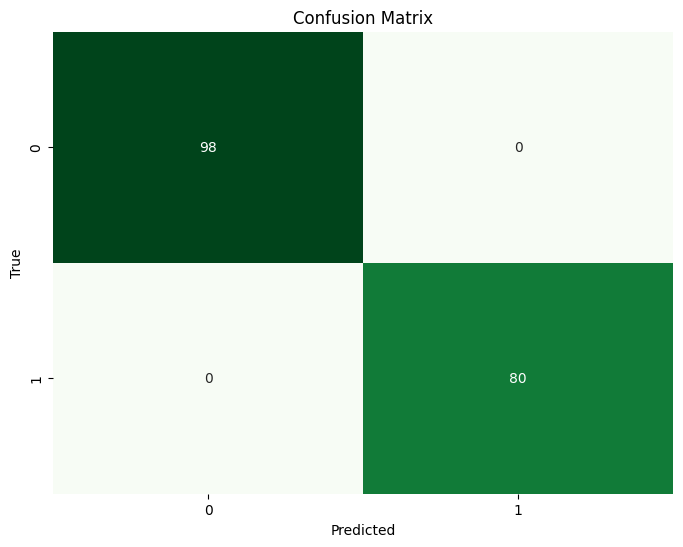

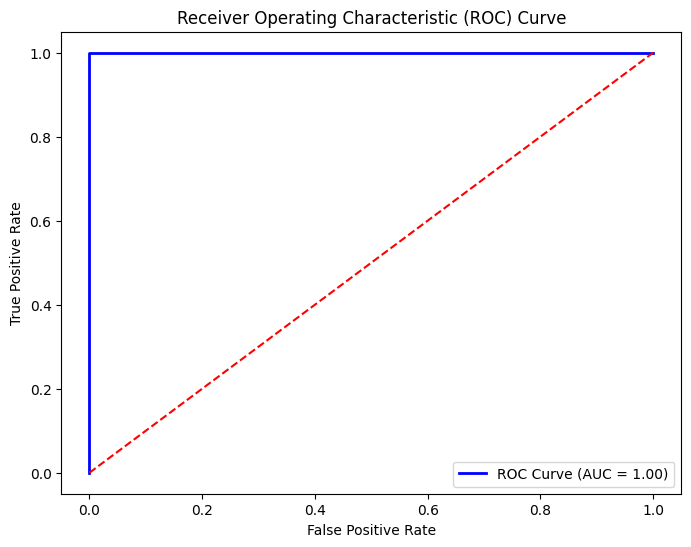

Accuracy: 1.0000 Precision: 1.0000 Recall: 1.0000 F1 Score: 1.0000 AUC Score: 1.0000 MCC: 1.0000 Kappa: 1.0000
Specificity: 1.0000


In [9]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

x_train, x_test, y_train, y_test = train_test_split(selected_x, y_augmented, test_size=0.2, random_state=42)


# Create a base Decision Tree classifier (a weak learner)
base_classifier = DecisionTreeClassifier(max_depth=1)  # You can adjust the hyperparameters

# Create an AdaBoost classifier using the base classifier
adaboost_classifier = AdaBoostClassifier(base_classifier, n_estimators=50, random_state=42)

# Train the classifier on the training data
adaboost_classifier.fit(x_train, y_train)

# Make predictions on the test set
y_pred = adaboost_classifier.predict(x_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')



# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print accuracy, precision, recall, F1-score, and confusion matrix
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Confusion Matrix:")
#print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Plot ROC curve
y_pred_prob = adaboost_classifier.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print('Accuracy: %.4f' % accuracy_score(y_test, y_pred), 'Precision: %.4f' % precision_score(y_test, y_pred), 'Recall: %.4f' % recall_score(y_test, y_pred),
      'F1 Score: %.4f' % f1_score(y_test, y_pred), 'AUC Score: %.4f' % roc_auc_score(y_test, y_pred),'MCC: %.4f' % matthews_corrcoef(y_test, y_pred), 'Kappa: %.4f' % cohen_kappa_score(y_test, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
print('Specificity: %.4f' % specificity)

# LDA + Stacking

Accuracy: 1.0
Confusion Matrix:
[[98  0]
 [ 0 80]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        98
         1.0       1.00      1.00      1.00        80

    accuracy                           1.00       178
   macro avg       1.00      1.00      1.00       178
weighted avg       1.00      1.00      1.00       178

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
Confusion Matrix:


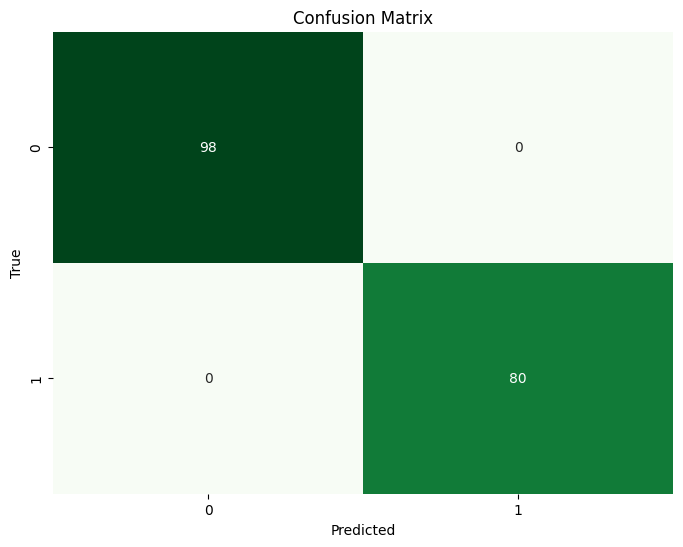

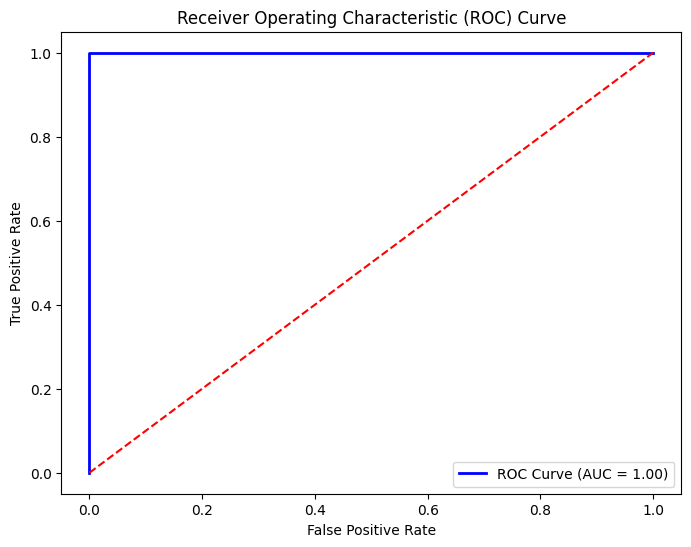

Accuracy: 1.0000 Precision: 1.0000 Recall: 1.0000 F1 Score: 1.0000 AUC Score: 1.0000 MCC: 1.0000 Kappa: 1.0000
Specificity: 1.0000


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import StackingClassifier

X_train, X_test, y_train, y_test = train_test_split(selected_x, y_augmented, test_size=0.2, random_state=42)

# Define base classifiers
base_classifiers = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, random_state=42))
]

# Define the meta-classifier
meta_classifier = LogisticRegression()

# Create the stacking classifier
stacking_classifier = StackingClassifier(estimators=base_classifiers, final_estimator=meta_classifier)

# Train the stacking classifier on the training data
stacking_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = stacking_classifier.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')



# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print accuracy, precision, recall, F1-score, and confusion matrix
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Confusion Matrix:")
#print(conf_matrix)




# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Plot ROC curve
y_pred_prob = stacking_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print('Accuracy: %.4f' % accuracy_score(y_test, y_pred), 'Precision: %.4f' % precision_score(y_test, y_pred), 'Recall: %.4f' % recall_score(y_test, y_pred),
      'F1 Score: %.4f' % f1_score(y_test, y_pred), 'AUC Score: %.4f' % roc_auc_score(y_test, y_pred),'MCC: %.4f' % matthews_corrcoef(y_test, y_pred), 'Kappa: %.4f' % cohen_kappa_score(y_test, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
print('Specificity: %.4f' % specificity)

# LDA + Voting

Accuracy on the test set with selected features: 0.9157303370786517
Accuracy: 0.9157303370786517
Precision: 0.9113924050632911
Recall: 0.9
F1-score: 0.9056603773584907
Confusion Matrix:


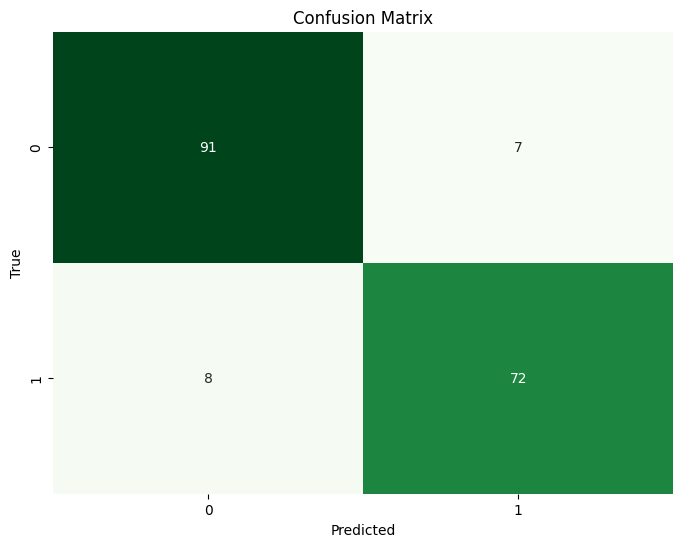

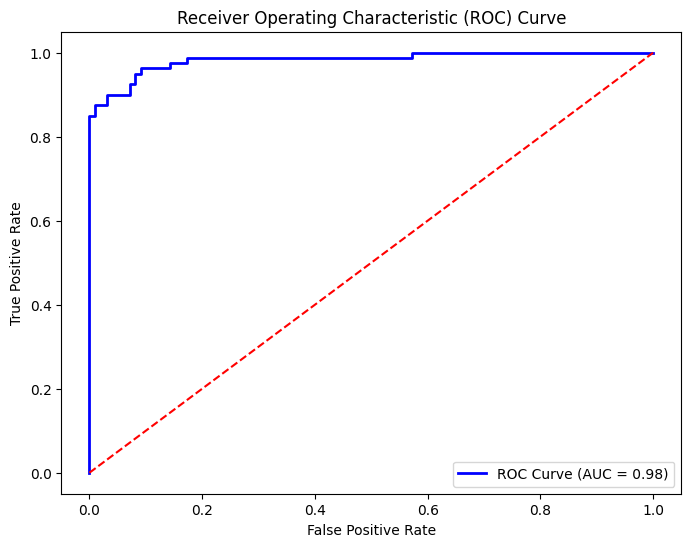

Accuracy: 0.9157 Precision: 0.9114 Recall: 0.9000 F1 Score: 0.9057 AUC Score: 0.9143 MCC: 0.8296 Kappa: 0.8295
Specificity: 0.9286


In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(selected_x, y_augmented, test_size=0.2, random_state=42)

# Define the base classifiers
log_reg_clf = LogisticRegression()
decision_tree_clf = DecisionTreeClassifier(max_depth=5)
svm_clf = SVC(kernel='linear', probability=True)

# Create a Voting Classifier using the base classifiers
voting_clf = VotingClassifier(
    estimators=[('lr', log_reg_clf), ('dt', decision_tree_clf), ('svm', svm_clf)],
    voting='soft'  # Use 'soft' voting to get class probabilities
)

# Train the Voting Classifier on the training data with selected features
voting_clf.fit(X_train, y_train)

# Make predictions on the test set with selected features
y_pred = voting_clf.predict(X_test)

# Evaluate the performance of the classifier with selected features
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set with selected features: {accuracy}")


# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print accuracy, precision, recall, F1-score, and confusion matrix
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Confusion Matrix:")
#print(conf_matrix)




# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Plot ROC curve
y_pred_prob = voting_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print('Accuracy: %.4f' % accuracy_score(y_test, y_pred), 'Precision: %.4f' % precision_score(y_test, y_pred), 'Recall: %.4f' % recall_score(y_test, y_pred),
      'F1 Score: %.4f' % f1_score(y_test, y_pred), 'AUC Score: %.4f' % roc_auc_score(y_test, y_pred),'MCC: %.4f' % matthews_corrcoef(y_test, y_pred), 'Kappa: %.4f' % cohen_kappa_score(y_test, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
print('Specificity: %.4f' % specificity)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


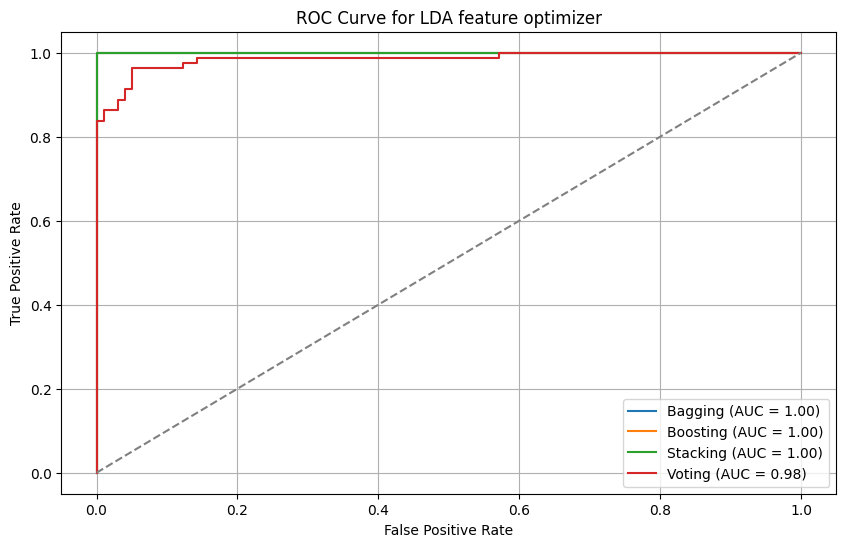

In [12]:
from sklearn.metrics import roc_curve, auc
# Initialize classifiers
classifiers = {
    "Bagging": bagging_classifier,
    "Boosting": adaboost_classifier,
    "Stacking": stacking_classifier,
    "Voting": voting_clf
}

# Plot ROC curves for each classifier
plt.figure(figsize=(10, 6))
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_score = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot ROC curve for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')

# Set plot labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LDA feature optimizer')
plt.legend()
plt.grid(True)
plt.show()